<a href="https://colab.research.google.com/github/prachuryanath/TF-Learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)**
Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

***We're going to go through the follow with TensorFlow:***
* Downloading and preparing 10% of the Food101 data (10% of training data)
* Training a feature extraction transfer learning model on 10% of the Food101 training data
* Fine-tuning our feature extraction model
* Saving and loaded our trained model
* Evaluating the performance of our Food Vision model trained on 10% of the training data
  * Finding our model's most wrong predictions
* Making predictions with our Food Vision model on custom images of food


In [2]:
# Are we using a GPU?
!nvidia-smi

Sat May 15 15:45:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Creating helper functions**

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-05-15 15:45:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-05-15 15:45:23 (103 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## **Downloading and preprocessing the data**

In [5]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2021-05-15 15:45:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   204MB/s    in 9.2s    

2021-05-15 15:45:34 (168 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_roll_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baklava'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baby_back_ribs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cup_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gnocchi'.
There are 0 directories and 75 images in

In [7]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


Wonderful! It looks like our data has been imported as expected with 75 images per class in the training set `(75 images 101 classes = 7575 images)` and 25250 images in the test set `(250 images 101 classes = 25250 images)`.



## **Train a big dog model with transfer learning on 10% of 101 food classes**
Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)


In [8]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [9]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential 

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet50
], name="data_augmentation")

In [10]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16711680/16705208 [==============================] - 0s 0us/step


In [11]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [12]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 [==============================] - 130s 393ms/step - loss: 3.9905 - accuracy: 0.1482 - val_loss: 2.6649 - val_accuracy: 0.3949
Epoch 2/5
237/237 [==============================] - 78s 328ms/step - loss: 2.4228 - accuracy: 0.4544 - val_loss: 2.2634 - val_accuracy: 0.4558
Epoch 3/5
237/237 [==============================] - 69s 290ms/step - loss: 1.9913 - accuracy: 0.5379 - val_loss: 2.0866 - val_accuracy: 0.4770
Epoch 4/5
237/237 [==============================] - 66s 278ms/step - loss: 1.7840 - accuracy: 0.5651 - val_loss: 2.0153 - val_accuracy: 0.4833
Epoch 5/5
237/237 [==============================] - 64s 267ms/step - loss: 1.6075 - accuracy: 0.6149 - val_loss: 1.9781 - val_accuracy: 0.4815


In [14]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 100s 126ms/step - loss: 1.7291 - accuracy: 0.5470


[1.729068636894226, 0.5470098853111267]

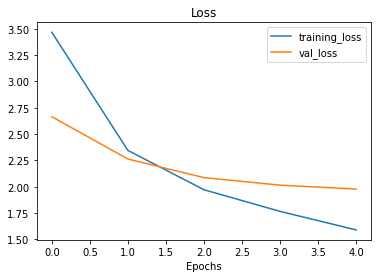

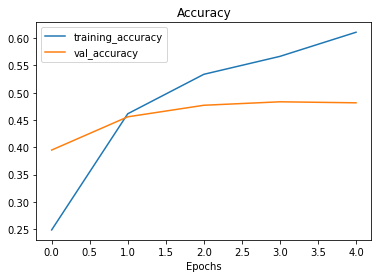

In [13]:
plot_loss_curves(history_all_classes_10_percent)

## **Fine-tuning**
Our feature extraction transfer learning model is performing well. Why don't we try to fine-tune a few layers in the base model and see if we gain any improvements?

The good news is, thanks to the ModelCheckpoint callback, we've got the saved weights of our already well-performing model so if fine-tuning doesn't add any benefits, we can revert back.

To fine-tune the base model we'll first set its trainable attribute to True, unfreezing all of the frozen.

Then since we've got a relatively small training dataset, we'll refreeze every layer except for the last 5, making them trainable.

In [15]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [16]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [17]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [18]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

Another 5 epochs should be enough to see whether any benefits come about (though we could always try more).

We'll start the training off where the feature extraction model left off using the `initial_epoch` parameter in the `fit()` function.

In [19]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 [==============================] - 71s 276ms/step - loss: 1.4054 - accuracy: 0.6435 - val_loss: 1.9032 - val_accuracy: 0.5077
Epoch 6/10
237/237 [==============================] - 61s 257ms/step - loss: 1.2562 - accuracy: 0.6702 - val_loss: 1.8831 - val_accuracy: 0.5124
Epoch 7/10
237/237 [==============================] - 59s 247ms/step - loss: 1.1545 - accuracy: 0.6924 - val_loss: 1.8578 - val_accuracy: 0.5201
Epoch 8/10
237/237 [==============================] - 57s 237ms/step - loss: 1.0939 - accuracy: 0.7159 - val_loss: 1.9078 - val_accuracy: 0.5154
Epoch 9/10
237/237 [==============================] - 57s 238ms/step - loss: 1.0463 - accuracy: 0.7214 - val_loss: 1.8850 - val_accuracy: 0.5135
Epoch 10/10
237/237 [==============================] - 58s 244ms/step - loss: 0.9867 - accuracy: 0.7409 - val_loss: 1.8420 - val_accuracy: 0.5283


In [20]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 99s 126ms/step - loss: 1.5960 - accuracy: 0.5810


[1.5960456132888794, 0.5810297131538391]

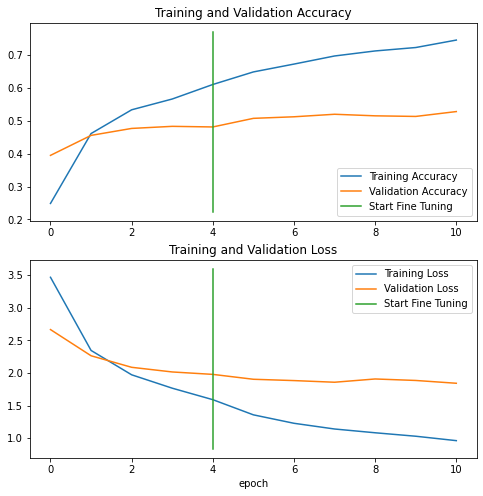

In [21]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

It seems that after fine-tuning, our model's training metrics improved significantly but validation, not so much. Looks like our model is starting to overfit.

This is okay though, its very often the case that fine-tuning leads to overfitting when the data a pre-trained model has been trained on is similar to your custom data.

In [22]:
# Save model to drive so it can be used later 
model.save("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/assets


## **Evaluating the performance of the big dog model across all different classes**
We've got a trained and saved model which according to the evaluation metrics we've used is performing fairly well.

But metrics schmetrics, let's dive a little deeper into our model's performance and get some visualizations going.



In [24]:
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
# model = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/") # path to drive model
model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

--2021-05-15 16:25:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.107.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  36.5MB/s    in 1.2s    

2021-05-15 16:25:59 (36.5 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [25]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 101s 126ms/step - loss: 1.8027 - accuracy: 0.6078


(1.8027204275131226, 0.6077623963356018)

### **Making predctions with our trained model**
To evaluate our trained model, we need to make some predictions with it and then compare those predictions to the test dataset.

Because the model has never seen the test dataset, this should give us an indication of how the model will perform in the real world on data similar to what it has been trained on.

In [26]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take

790/790 [==============================] - 97s 121ms/step


In [27]:
# How many predictions are there?
len(pred_probs)
# What's the shape of our predictions?
pred_probs.shape

(25250, 101)

What we've got is often referred to as a predictions probability tensor (or array).

Let's see what the first 10 look like.

In [29]:
# How do they look?
pred_probs[:10]

array([[5.9542004e-02, 3.5742048e-06, 4.1376974e-02, ..., 1.4138707e-09,
        8.3530831e-05, 3.0897511e-03],
       [9.6401680e-01, 1.3753246e-09, 8.4780657e-04, ..., 5.4286997e-05,
        7.8362204e-12, 9.8466024e-10],
       [9.5925879e-01, 3.2533586e-05, 1.4866921e-03, ..., 7.1891071e-07,
        5.4397117e-07, 4.0275969e-05],
       ...,
       [4.7313261e-01, 1.2931220e-07, 1.4805585e-03, ..., 5.9750013e-04,
        6.6969093e-05, 2.3469209e-05],
       [4.4571821e-02, 4.7265530e-07, 1.2258515e-01, ..., 6.3498514e-06,
        7.5318521e-06, 3.6778734e-03],
       [7.2438997e-01, 1.9249742e-09, 5.2310865e-05, ..., 1.2291356e-03,
        1.5792692e-09, 9.6395699e-05]], dtype=float32)

In [30]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.95420040e-02 3.57420481e-06 4.13769744e-02 1.06605957e-09
 8.16144308e-09 8.66396554e-09 8.09270432e-07 8.56525787e-07
 1.98590351e-05 8.09776793e-07 3.17278026e-09 9.86737405e-07
 2.85321876e-04 7.80491949e-10 7.42302276e-04 3.89165252e-05
 6.47403658e-06 2.49773507e-06 3.78911318e-05 2.06783668e-07
 1.55384660e-05 8.15070223e-07 2.62305161e-06 2.00107237e-07
 8.38273706e-07 5.42161388e-06 3.73908892e-06 1.31505820e-08
 2.77614570e-03 2.80519434e-05 6.85626778e-10 2.55748546e-05
 1.66889280e-04 7.64068475e-10 4.04528779e-04 1.31506335e-08
 1.79573601e-06 1.44482021e-06 2.30628569e-02 8.24668518e-07
 8.53658491e-07 1.71386603e-06 7.05251614e-06 1.84022007e-08
 2.85533758e-07 7.94834523e-06 2.06815321e-06 1.85251167e-07
 3.36197701e-08 3.15225829e-04 1.04109231e-05 8.54482778e-07
 8.47418606e-01 1.05554454e-05 4.40946224e-07 3.74043229e-05
 3.53062278e-05 3.24891298e-05 6.73148679e-

As we discussed before, for each image tensor we pass to our model, because of the number of output neurons and activation function in the last layer` (layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax")`, it outputs a prediction probability between 0 and 1 for all each of the 101 classes.



In [31]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

Beautiful! We've now got the predicted class index for each of the samples in our test dataset.

We'll be able to compare these to the test dataset labels to further evaluate our model.

To get the test dataset labels we can unravel our test_data object (which is in the form of a `tf.data.Dataset`) using the `unbatch()` method.

Doing this will give us access to the images and labels in the test dataset. Since the labels are in one-hot encoded format, we'll take use the argmax() method to return the index of the label.

In [32]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [33]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

25250

### Evaluating our models predictions